<h1 align=center><font size = 5>Where could I open my business?</font></h1>

## Introduction/Business Problem

<p style='text-align: justify;'>The problem that I want to tackle with my capstone project is to determine which neighborhood in a given city would be the best to open a new business. In order to reduce the scope of the problem, given  I've decided to restrict it to opening a new pizza parlor, that might even be something of interest for big food companies such as Pizza Hut and Domino's. <br>
The way that I've envisioned for such endeavor would be to cluster neighborhoods based on the number of pizzerias and look for clusters where there aren't that many pizzerias. </p>

## Data
<p style='text-align: justify;'>In order to tackle this problem that data that would be required would be a dataframe containing every single neighborhood in a given city, with their names and by using the GeoPy service it would be possible to acquire their latitude and longitude, with those all that's left is to query the foursquare API in order to organize all the venues in a given city into a dataframe. <br> With the clustering of said dataframe one could distinguish the neighborhoods that are suitable for new pizza parlors.</p>
 

In [183]:
import numpy as np # library to handle data in a vectorized manner
import matplotlib.pyplot as plt
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

In [184]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [185]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [186]:
#newyork_data

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [187]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [188]:
#neighborhoods_data[0]

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [189]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [190]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [191]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [192]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [193]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Using geopy to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [194]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [195]:
neighborhoods['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

### This is where one can select the Borough that would be studied in the notebook.

In [196]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [197]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


As we did with all of New York City, let's visualize Manhattan the neighborhoods in it.

In [198]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [199]:
CLIENT_ID = 'J1ZT0FMNMMSBP5CIFPJ4HKVB3D43OATGVKCPNVIK4TY41ZKV' # your Foursquare ID
CLIENT_SECRET = 'LJAEYUT5KMHKJLFXWMCEB5KSNVICGTNNQECG5QELLVMUOCPH' # your Foursquare Secret
VERSION = '20190604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J1ZT0FMNMMSBP5CIFPJ4HKVB3D43OATGVKCPNVIK4TY41ZKV
CLIENT_SECRET:LJAEYUT5KMHKJLFXWMCEB5KSNVICGTNNQECG5QELLVMUOCPH


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [200]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [201]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value
LIMIT = 100
neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


In [202]:
def getNearbyVenuesCategories(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [203]:
# type your answer here

manhattan_categories = getNearbyVenuesCategories(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )['Venue Category']


Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


### This is where the venue categories are displayed.

In [204]:
list(sorted(manhattan_categories.unique()))

['Accessories Store',
 'Adult Boutique',
 'Afghan Restaurant',
 'African Restaurant',
 'American Restaurant',
 'Animal Shelter',
 'Antique Shop',
 'Arcade',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auditorium',
 'Australian Restaurant',
 'Austrian Restaurant',
 'Auto Workshop',
 'BBQ Joint',
 'Baby Store',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Basketball Court',
 'Beer Bar',
 'Beer Garden',
 'Beer Store',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bike Shop',
 'Bike Trail',
 'Bistro',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Boxing Gym',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Bridal Shop',
 'Bridge',
 'Bubble Tea Shop',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Bus Station',
 'Bus Stop',
 'Business Service',
 'Butcher',
 'Cafeteria',
 'Café',
 'Cambodian Restaurant',
 'Camera Store',
 'Candy Store',


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [205]:
# type your answer here
radius = 500
latitude = neighborhood_latitude
longitude = neighborhood_longitude
LIMIT = 100
search_query=''
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url
print(' .... OK!')

 .... OK!


Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [206]:
results = requests.get(url).json()
#results

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [207]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## 2. Explore Neighborhoods in Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [208]:
def getNearbyVenues(names, latitudes, longitudes, query, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            query
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### This is where you can change the venue category that will be studied, by changing the value of the 'venue' variable

In [210]:
# type your answer here
venue = 'Pizza Place'
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                   query=venue
                                  )


Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [211]:
print(manhattan_venues.shape)
manhattan_venues.head()

(749, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.910660,Cafeccino Bakery,40.880068,-73.907064,Pizza Place
2,Chinatown,40.715618,-73.994279,Scarr's Pizza,40.715335,-73.991649,Pizza Place
3,Chinatown,40.715618,-73.994279,Williamsburg Pizza,40.718303,-73.991046,Pizza Place
4,Chinatown,40.715618,-73.994279,Margherita NYC,40.719228,-73.996896,Pizza Place


Let's check how many venues were returned for each neighborhood

In [212]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,10,10,10,10,10,10
Carnegie Hill,21,21,21,21,21,21
Central Harlem,6,6,6,6,6,6
Chelsea,25,25,25,25,25,25
Chinatown,20,20,20,20,20,20
Civic Center,32,32,32,32,32,32
Clinton,26,26,26,26,26,26
East Harlem,22,22,22,22,22,22
East Village,40,40,40,40,40,40


#### Let's find out how many unique categories can be curated from all the returned venues

In [213]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 22 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [214]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,American Restaurant,Arcade,Bakery,Bar,Café,Coffee Shop,Deli / Bodega,Dessert Shop,Food & Drink Shop,Gourmet Shop,Grocery Store,Hotel Bar,Italian Restaurant,New American Restaurant,Pizza Place,Pub,Sandwich Place,Seafood Restaurant,Sports Bar,Steakhouse,Vegetarian / Vegan Restaurant,Wine Bar
0,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [215]:
manhattan_onehot.shape

(749, 23)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [216]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').sum().reset_index()
manhattan_grouped

,Neighborhood,American Restaurant,Arcade,Bakery,Bar,Café,Coffee Shop,Deli / Bodega,Dessert Shop,Food & Drink Shop,Gourmet Shop,Grocery Store,Hotel Bar,Italian Restaurant,New American Restaurant,Pizza Place,Pub,Sandwich Place,Seafood Restaurant,Sports Bar,Steakhouse,Vegetarian / Vegan Restaurant,Wine Bar
0,Battery Park City,0,0,0,0,0,0,0,0,0,1,0,0,0,0,9,0,0,0,0,0,0,0
1,Carnegie Hill,0,0,0,0,1,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0
2,Central Harlem,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0
3,Chelsea,0,0,0,0,0,1,0,0,0,0,0,0,1,0,23,0,0,0,0,0,0,0
4,Chinatown,0,0,1,0,0,0,0,0,0,0,0,0,2,0,16,0,0,1,0,0,0,0
5,Civic Center,0,0,1,0,0,0,0,0,1,0,0,0,0,0,30,0,0,0,0,0,0,0
6,Clinton,1,0,0,0,0,0,0,0,0,0,0,0,1,1,23,0,0,0,0,0,0,0
7,East Harlem,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0
8,East Village,0,0,0,0,0,0,0,0,0,0,0,0,1,0,38,0,0,0,0,0,1,0
9,Financial District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,1,0,0


#### Let's confirm the new size

In [217]:
manhattan_grouped.shape

(40, 23)

#### Let's print each neighborhood along with the top 5 most common venues

In [218]:
manhattan_pizzerias = pd.DataFrame()
manhattan_pizzerias['Neighborhood'] = manhattan_grouped['Neighborhood']

In [219]:
manhattan_pizzerias[venue] = manhattan_grouped[venue]

#### Let's confirm the new size

In [220]:
manhattan_pizzerias

,Neighborhood,Pizza Place
0,Battery Park City,9
1,Carnegie Hill,20
2,Central Harlem,6
3,Chelsea,23
4,Chinatown,16
5,Civic Center,30
6,Clinton,23
7,East Harlem,22
8,East Village,38
9,Financial District,31


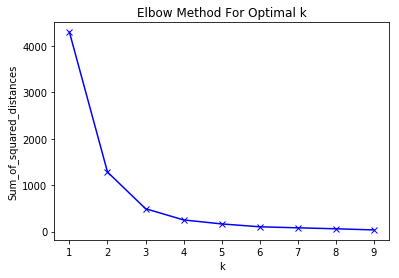

In [221]:
# run k-means clustering
manhattan_clustering = manhattan_pizzerias.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(init="k-means++",n_clusters=k, random_state=0).fit(manhattan_clustering)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [222]:
# set number of clusters
kclusters = 3
# run k-means clustering
kmeans = KMeans(init="k-means++",n_clusters=kclusters, random_state=0).fit(manhattan_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 2, 0, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2], dtype=int32)

In [223]:
# add clustering labels

manhattan_pizzerias['Cluster Labels']= kmeans.labels_

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(manhattan_pizzerias.set_index('Neighborhood'), on='Neighborhood')

In [224]:
manhattan_merged.dropna(inplace=True)
manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Pizza Place,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,2,0
1,Manhattan,Chinatown,40.715618,-73.994279,16,2
2,Manhattan,Washington Heights,40.851903,-73.936900,11,0
3,Manhattan,Inwood,40.867684,-73.921210,11,0
4,Manhattan,Hamilton Heights,40.823604,-73.949688,9,0


In [225]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 100px; height: 120px; 
                            border:1px solid black; z-index:9999; font-size:14px;
                            background-color:white
                            ">&nbsp; Legend: <br>
                              &nbsp; Cluster 0 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i><br>
                              &nbsp; Cluster 1 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:purple"></i>
                              &nbsp; Cluster 2 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:#d7ffab"></i>
                </div>
                ''' 

map_clusters.get_root().html.add_child(folium.Element(legend_html))
map_clusters      


## 4. Exploring the clusters

The first cluster is formed by neighborhoods that have between 1 and 13 pizza places.

In [226]:
cluster_0=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0.0, ['Neighborhood','Pizza Place']]
cluster_0

,Neighborhood,Pizza Place
0,Marble Hill,2
2,Washington Heights,11
3,Inwood,11
4,Hamilton Heights,9
5,Manhattanville,4
6,Central Harlem,6
8,Upper East Side,13
11,Roosevelt Island,3
13,Lincoln Square,5
21,Tribeca,6


The second cluster is formed by neighborhoods that have between 27 and 37 pizza places.

In [227]:
cluster_1 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1.0, ['Neighborhood','Pizza Place']]
cluster_1

,Neighborhood,Pizza Place
15,Midtown,33
16,Murray Hill,33
19,East Village,38
23,Soho,27
29,Financial District,31
31,Noho,37
32,Civic Center,30
33,Midtown South,38


Finally, the last one has between 16 and 22 pizzerias around.

In [228]:
cluster_2 =  manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2.0, ['Neighborhood','Pizza Place']]
cluster_2

,Neighborhood,Pizza Place
1,Chinatown,16
7,East Harlem,22
9,Yorkville,16
10,Lenox Hill,19
12,Upper West Side,17
14,Clinton,23
17,Chelsea,23
18,Greenwich Village,24
20,Lower East Side,17
22,Little Italy,20


## 5. Conclusion

By looking at the clusters that were formed it's easy to pinpoint some neighborhoods within the first cluster that would be good places to start a new pizza business, such as Marble Hill and Stuyvesant Town, with Manhattanville and Morningside Heights right after. It's curious to look at the actual third place of this cluster, Roosevelt Island, with 3 pizza places in a 500 meter radius, since it's an actual island in the middle of the urban area and probably would have to overcome this geographical limitation. <br> Regarding the other two clusters it's clear that they both have enough pizzerias, however one could still hope to enter the pizza scene by experimenting with the concept, therefore, it would attract a great costumer base that already existed, given the number of pizzerias in these neighborhoods.